# File to calculate PCA 
 It creates PCA_waveforms file with PCA and clustering data
 It actualizes the PCA cluster identity in PCA_wave field to wavedataAll

In [61]:
 %pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [62]:
from pylab import *
from scipy import *
from scipy import stats, io
import numpy as np
import struct
import tables as tb
from attrdict import AttrDict
import matplotlib.pyplot as plt
import os as os
from phy.io import KwikModel
import codecs as codecs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

In [63]:
#----------------------------------------------------------------------------------------
#SAVING BINARY OBJECTS DATA
#need to automate data folder creation
#----------------------------------------------------------------------------------------
import pickle 

def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Make PCA

In [234]:
#----------------------------------------------------------------------------------------
# GEN  TALBLES
#----------------------------------------------------------------------------------------
# This generates the PCA tables, rows are the 7 parameters, columns are the neurons
def GenTable(Params) :
    
    idx = list(Params.keys())
    tot_neurons = len(idx)
    
    params_table = np.zeros([7,tot_neurons])
    neuron_labels = []
    neuron_i = 0
    for neuron in idx:
        
        localp = Params[neuron].params
        #this gives width, relative crossings, peak values, relative peaks
        #parnames:
        #('widths0-25-50-tot-tot_int', 'cross1-2-3', 'crossrel1-2-3', 'peakVals', 'peaks1-2', 'peaksrel1-2', 'mins')

        parvals = [localp[0][4],localp[2][0],localp[2][1],localp[3][0],(localp[3][0])/(localp[3][1]),localp[5][0],localp[5][1]]
        params_table[:,neuron_i] = parvals
        neuron_labels.append(neuron)
        neuron_i +=1
            
    pnames = ['width','crel1','crel2','peakV1','peakV2/V1','prel1','prel2']
    
    return pnames, neuron_labels, tot_neurons, params_table

In [235]:
#----------------------------------------------------------------------------------------
# UPDATING dataAll with PCA projections and saving PCAwaveforms analysis
#----------------------------------------------------------------------------------------

#load datafile
print('   loading waves')
#------------------------------------------------
#here I load all the data of the waveforms in from a single file
FolderWaves = '/home/matias/WORKSPACE/S2_git/'    
data = FolderWaves +'data/wavedataAll'

Wavedata= load_obj(data)


#------------------------------------------------
print('   computing PCA')
#------------------------------------------------
# I build the table and get names and labels of columns (neurons)
pnames, neuron_labels, tot_neurons, PCA_table = GenTable(Wavedata)

#mean params values (its a p x n matrix p params, n neurons)
PCA_mean = np.mean(PCA_table,axis=1)
#substract mean
PCA_center = np.transpose(np.transpose(PCA_table)- PCA_mean)
#calculate covariance matrix
PCA_covmats = np.cov(PCA_center)
#eigs and eigvec
PCA_eigvals, PCA_eigvecs = np.linalg.eigh(PCA_covmats)
# projection matrix for each neuron (p projections x n neurons)
PCA_proj = np.dot(PCA_table.T,PCA_eigvecs).T

#------------------------------------------------
#updating the data dictionary with the projections
i=0
for idx in neuron_labels:
    Wavedata[idx]['PCA_wave']=PCA_proj[:,i]
    i+=1
    
save_obj(Wavedata,data)
#-----------------------------------------------------

#Here I save a new pickle with the PCA info
#-----------------------------------------------------
PCA_waveforms = dict()
PCA_waveforms['PCA_table']=PCA_table
PCA_waveforms['PCA_covmats']=PCA_covmats
PCA_waveforms['PCA_eigvals']=PCA_eigvals
PCA_waveforms['PCA_eigvecs']=PCA_eigvecs
PCA_waveforms['PCA_names']=pnames
save_obj(PCA_waveforms, FolderWaves + 'data/PCA_waveforms')
#-----------------------------------------------------

   loading waves
   computing PCA


# Display Eigvecs and Eigvals

10
6


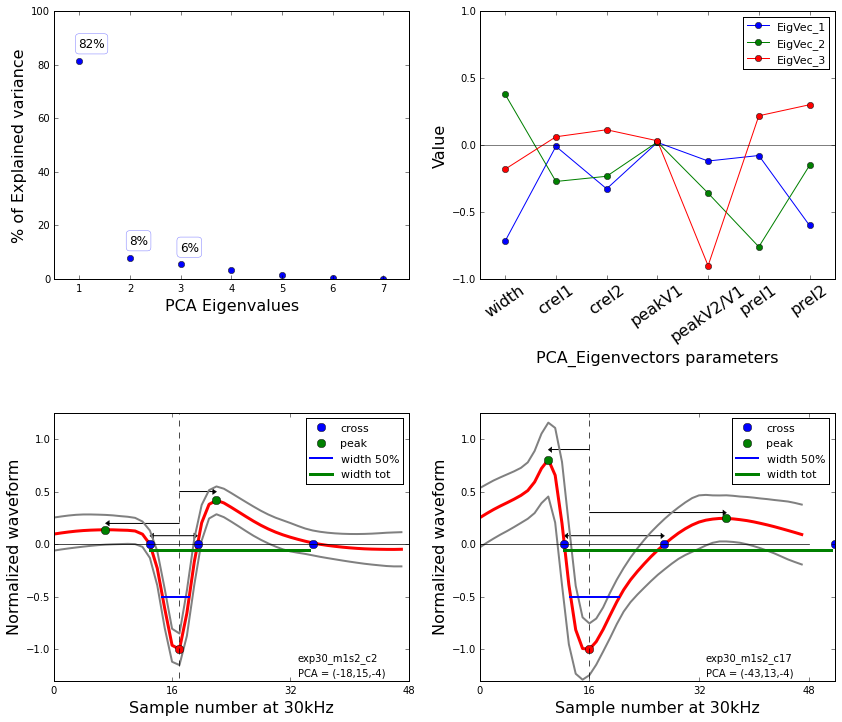

In [260]:
data = FolderWaves +'data/PCA_waveforms'
PCA = load_obj(data)

fig = figure(figsize=(14,12))
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#----------------------------------------
#----------------------------------------
# Subplot Eigenvalues

ax1 = fig.add_subplot(2,2,1)

names = PCA['PCA_names']
eigs =PCA['PCA_eigvals']

toteig = sum(eigs)

#----------------------------------------
plot(eigs/toteig*100, 'o')
ax1.set_xticks(arange(7)[::-1])
ax1.set_xticklabels(arange(7)+1)
ax1.set_xlabel('PCA Eigenvalues',size=16)
ax1.set_ylabel('% of Explained variance',size=16)

ax1.set_ylim([0,100])
ax1.set_xlim([-0.5,6.5])
#----------------------------------------

perc = eigs[6]/sum(eigs[:])*100
perc1 = eigs[5]/sum(eigs[:])*100
perc2 = eigs[4]/sum(eigs[:])*100

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=0.5, alpha = 0.5)
ax1.annotate(str(int(round(perc,0)))+'%', xy=(6,perc), xytext=(6, perc+5),size=12,bbox=bbox_props)
ax1.annotate(str(int(round(perc1,0)))+'%', xy=(5,perc1), xytext=(5, perc1+5),size=12,bbox=bbox_props)
ax1.annotate(str(int(round(perc2,0)))+'%', xy=(4,perc2), xytext=(4, perc2+5),size=12,bbox=bbox_props)

ax1.invert_xaxis()

#----------------------------------------
#----------------------------------------
# Subplot Eigenvectos


ax2 = fig.add_subplot(2,2,2)

ax2.set_xticks(arange(7))
ax2.set_xticklabels(names, size=16, rotation = 35)


ax2.set_xlabel('PCA_Eigenvectors parameters',size=16)
ax2.set_ylabel('Value',size=16)

ax2.set_ylim([-1,1])
ax2.set_xlim([-0.5,6.5])


plot(PCA['PCA_eigvecs'][:,6],'-o',label = 'EigVec_1')
plot(PCA['PCA_eigvecs'][:,5],'-o',label = 'EigVec_2')
plot(PCA['PCA_eigvecs'][:,4],'-o',label = 'EigVec_3')


plot([-1,7],[0,0],color='k', linewidth = 0.5)


ax2.legend(loc='upper right', numpoints=1, ncol=1,fontsize=11, bbox_to_anchor=(1, 1.))

#----------------------------------------
#----------------------------------------
# Subplot Waveforms examples

data = FolderWaves +'data/wavedataAll'
Wavedata = load_obj(data)

neuronF = 'exp30_m1s2_c2'
neuronR = 'exp30_m1s2_c17'

Neurondata = [Wavedata[neuronF],Wavedata[neuronR]]

i=3
for wavedata in Neurondata:
    ax3 = fig.add_subplot(2,2,i)

    ax3.set_xticks([0,16,32,48])
    ax3.set_ylim([-1.3,1.25])
    
    
    ax3.set_xlabel('Sample number at 30kHz',size=16)
    ax3.set_ylabel('Normalized waveform',size=16)
    
    m =-wavedata.bigwave/min(wavedata.bigwave)
    s =-wavedata.bigwavestd/min(wavedata.bigwave)

    ax3.plot(arange(48),m,color='red',linewidth = 3 )
    ax3.plot(arange(48),m+s,color='gray',linewidth = 2)
    ax3.plot(arange(48),m-s,color='gray',linewidth = 2)     

    width = wavedata.params[0]
    cross = wavedata.params[1]
    crossrel = wavedata.params[2]
    peaksV = wavedata.params[3]
    peaks = wavedata.params[4]
    peaksrel = wavedata.params[5]
    print(-peaksrel[0])
    mins = wavedata.params[6]

    ax3.plot(cross,[0,0,0],'o',markersize=8,  label = 'cross')
    ax3.plot(peaks,-np.array(peaksV),'o',markersize=8,  label = 'peak')
    ax3.plot(mins[0],-1,'o',markersize=8)

    shift=0.8
    if i==3: shift=1.7
    ax3.plot([cross[0]+shift,cross[0]+width[2]+shift],-np.array([1,1])*0.5,'b', label = 'width 50%',linewidth = 2)
    ax3.plot([cross[0],cross[0]+width[4]-0.5],[-0.05,-0.05],'g', label = 'width tot',linewidth = 3)
    #ax3.plot([cross[0]+1,cross[0]+width[2]+1],-np.array([1,1])*0.5,'r')
    
    ax3.plot([25,25+15],[-1,-1],color='k',linewidth = 2)     
    ax3.text(27,-0.9,'0.5ms', size = 8, fontweight='bold')
    
    if i==3:
         ax3.arrow(mins[0],0.08,crossrel[1]-0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel',linewidth = 0.5)
         ax3.arrow(mins[0],0.08,crossrel[0]+0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel2',linewidth = 0.5)
        
         ax3.arrow(mins[0],0.2,peaksrel[0]+0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel',linewidth = 0.5)
         ax3.arrow(mins[0],0.5,peaksrel[1]-0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel2',linewidth = 0.5)
        
         ax3.plot([mins[0],mins[0]],[-1.5,1.5],'k--', linewidth = 0.7,)
        
         ax3.text(33,-1.1,neuronF)
    else:
         ax3.arrow(mins[0],0.08,crossrel[1]-0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel',linewidth = 0.5)
         ax3.arrow(mins[0],0.08,crossrel[0]+0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel2',linewidth = 0.5)
        
         ax3.arrow(mins[0],0.9,peaksrel[0]+0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel',linewidth = 0.5)
         ax3.arrow(mins[0],0.3,peaksrel[1]-0.5,0, head_width=0.05, head_length=0.5, fc='k', ec='k',label = 'crel2',linewidth = 0.5)
        
         ax3.plot([mins[0],mins[0]],[-1.5,1.5],'k--', linewidth = 0.7)
        
         ax3.annotate(neuronR,xy=(33,-1.1))
    i+=1

    ax3.annotate('PCA = (' +str(int(wavedata.PCA_wave[6]))+','+str(int(wavedata.PCA_wave[5]))+','+str(int(wavedata.PCA_wave[4]))+')',xy=(33,-1.25))
    ax3.plot([0,48],[0,0],color='k', linewidth = 0.7)
    

    ax3.legend(loc='upper right', numpoints=1, ncol=1,fontsize=11, bbox_to_anchor=(1, 1.))
    

pdf_files_directory ='/home/matias/WORKSPACE/OUTPUT/'
    
fig.savefig(pdf_files_directory + 'PCA_waveforms.pdf', format='pdf')


# Cluster Waveforms

dict_keys(['exp', 'bigwave', 'shank', 'PCA_wave', 'meas', 'params', 'meanwave', 'stdwave', 'parnames', 'electrodemax', 'clus_label', 'bigwavestd', 'waves'])


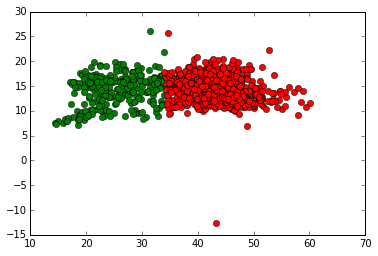

In [231]:
from sklearn.cluster import KMeans

data = FolderWaves +'data/wavedataAll'
Wavedata = load_obj(data)

#----------------------------------------
# Get my seeds 
PCA_seeds = []

neurons = []
neuron = 'exp28_m3s4_c100'
neurons.append(neuron)
neuron = 'exp26_m2s1_c7'
neurons.append(neuron)
neuron = 'exp30_m1s2_c2'
neurons.append(neuron)
neuron = 'exp30_m1s2_c17'
neurons.append(neuron)

i=0
for n in neurons:
    PCA_seeds.append(np.array([Wavedata[n].PCA_wave[6],Wavedata[n].PCA_wave[5],Wavedata[n].PCA_wave[4]]))
    i+=1
PCA_seeds= asarray(PCA_seeds)
#----------------------------------------
# Get my matrix of PCAs
PCA = []

idx = list(Wavedata.keys())
i=0
for n in idx:
    PCA.append([Wavedata[n].PCA_wave[6],Wavedata[n].PCA_wave[5],Wavedata[n].PCA_wave[4]])
    i+=1
PCA= asarray(PCA)
#----------------------------------------

K=2
    
km = KMeans(n_clusters = K)#,init=PCA_seeds)
clusters = km.fit(PCA)

fig = figure()

c = clusters.labels_
for i in arange(len(PCA)):
    plot(-PCA[i,0],PCA[i,1],'o', color = 'r' if c[i]==0 else 'g')

    
    
i=0    
for n in idx:
    Wavedata[n]['clus_label'] = clusters.labels_[i]
    i+=1

    
print(Wavedata[n].keys())

save_obj(Wavedata, data)



In [261]:
data = FolderWaves +'data/PCA_waveforms'
PCA = load_obj(data)

PCA.update({'Kmeans':clusters}, )

PCA.keys()

save_obj(PCA,data)

In [233]:
#update spiketimes to wavedataAll

FolderWaves = '/home/matias/WORKSPACE/S2_git/'    
data = FolderWaves +'data/wavedataAll'
wavedata = load_obj(data)


idx = list(wavedata.keys())

print(len(idx))
#wavedata = dict()

idx = list(wavedata.keys())

dataspikes = FolderWaves +'data/wavedataAllspikes'
wavedata2 = load_obj(dataspikes)


for n in idx:
    wavedata[n].update(wavedata2[n])    
    if wavedata[n].exp==24:
        wavedata[n].update({'spike_times': wavedata[n].spiketimes})
        del wavedata[n].spiketimes
    
data = FolderWaves +'data/wavedataAll2'




save_obj(wavedata, data)

idx = list(wavedata.keys())

len(idx)


1607


1607

In [100]:
wavedata[idx[1]].keys()

dict_keys(['exp', 'bigwave', 'shank', 'PCA_wave', 'meas', 'Nspikes', 'params', 'measLength', 'meanwave', 'stdwave', 'parnames', 'electrodemax', 'clus_label', 'bigwavestd', 'spike_times', 'waves'])

In [220]:
PCA.keys()

dict_keys(['PCA_eigvals', 'PCA_table', 'PCA_covmats', 'PCA_names', 'PCA_eigvecs', 'Kmeans'])

In [230]:
clusters.cluster_centers_[0:2]

array([[-24.03628742,  13.91222236,  -4.2859602 ],
       [-45.93825351,  13.75544902,  -4.09548161]])